In [114]:
import numpy as np
import numpy.random as rndm
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

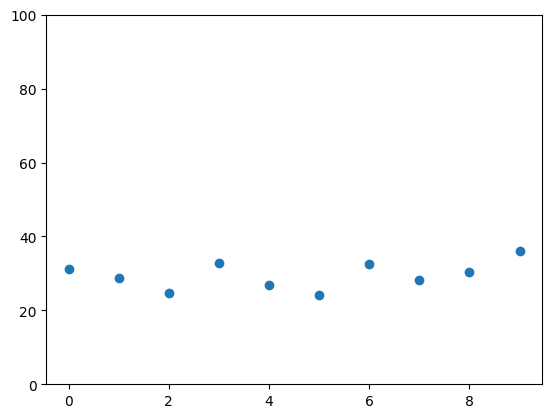

In [3]:
plt.scatter(range(10), rndm.normal(30, 4, 10))
plt.ylim((0,100))
plt.show()

In [4]:
prices = rndm.normal(0.5, 0.1, 100)
uncensored = prices[:10]
censored = prices[10:]
rnd_bids = 0.3 + 0.4 * rndm.rand(len(censored))
rnd_deltas = rnd_bids > censored
print(censored.std())
print(uncensored.std())
print(prices.std())
print(prices.mean())

0.09497688496237801
0.12060072296236579
0.09844758995917136
0.5063199292681498


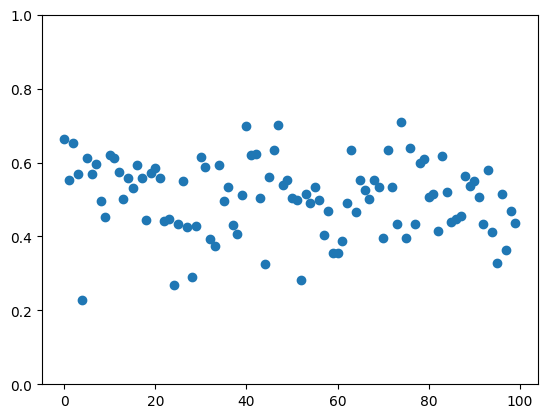

In [5]:
plt.scatter(range(len(prices)), prices)
plt.ylim((0,1))
plt.show()

In [6]:
# eps-Greedy algorithm
inf_y = 0
sup_y = 1
nb_arms = 5
zones = np.linspace(inf_y, sup_y, nb_arms + 1)
eps = 0.33
rndm.seed(5432)
def reward(bid, tau):
    return (sup_y - bid) * (tau <= bid)
avg_reward_arms = np.zeros(nb_arms)
count_arms = np.zeros(nb_arms)
# Initialisation
for arm in range(nb_arms):
    bid = zones[arm] + (zones[arm+1] - zones[arm]) * rndm.rand()
    avg_reward_arms[arm] = reward(bid, prices[arm])
    count_arms[arm] += 1
# Exploration/Exploitation:
for t, tau in enumerate(prices[arm:]):
    if rndm.rand() < eps : # Exploration
        arm = rndm.randint(0,nb_arms)
    else:
        arm = np.argmax(avg_reward_arms)
    bid = zones[arm] + (zones[arm+1] - zones[arm]) * rndm.rand()
    count_arms[arm] += 1
    avg_reward_arms[arm] = ((count_arms[arm] - 1) * avg_reward_arms[arm] + reward(bid, tau)) / count_arms[arm]
print(avg_reward_arms)
print(count_arms)
sum(avg_reward_arms * count_arms)

[0.         0.07669294 0.05060814 0.28904584 0.08567558]
[ 6. 10.  8. 73.  4.]


22.614842972818302

In [7]:
def get_fraction_1_tau_known(t, tau, sigma):
    t_sigma = (t - tau) / sigma
    return sigma ** 2 * (1 - t_sigma * norm.pdf(t_sigma)/norm.cdf(t_sigma))
def get_fraction_0_tau_known(t, tau, sigma):
    t_sigma = (t - tau) / sigma
    return sigma ** 2 * (1 + t_sigma * norm.pdf(t_sigma)/(1 - norm.cdf(t_sigma)))
def EM_known_tau(X_uncensored, bids, deltas, sigma_0,  tau, max_step = 100):
    step = 1
    sigma_n = sigma_0
    results = np.zeros(max_step)
    results[0] = sigma_n
    N = len(X_uncensored)
    M = len(bids)
    if N > 0:
        sum_uncensored = sum((X_uncensored - tau)**2)
    else:
        sum_uncensored = 0
    # print(np.sqrt(sum_uncensored/N))
    while step < max_step:
        sum_censored = 0
        if M > 0:
            for i, bid in enumerate(bids):
                if deltas[i] == 0:
                    sum_censored += get_fraction_0_tau_known(bid, tau, sigma_n)
                else:
                    sum_censored += get_fraction_1_tau_known(bid, tau, sigma_n)
        sigma_n = np.sqrt((sum_uncensored + sum_censored)/ (N + M))
        results[step] = sigma_n
        step += 1
    return results

In [8]:
def get_fraction_1_unknown(t, tau, sigma):
    t_sigma = (t - tau) / sigma
    return - norm.pdf(t_sigma)/norm.cdf(t_sigma)
def get_fraction_0_unknown(t, tau, sigma):
    t_sigma = (t - tau) / sigma
    return norm.pdf(t_sigma)/(1 - norm.cdf(t_sigma))
def EM_unknown(X_uncensored, bids, deltas, sigma_0, tau_0, conv = 1e-3, max_step = 100):
    step = 1
    tau_n = tau_0
    sigma_n = sigma_0
    taus = [tau_n]
    sigmas = [sigma_n]
    N = len(X_uncensored)
    M = len(bids)
    M_N = M + N
    sum_uncensored = sum(X_uncensored)
    while step < max_step:
        if N > 0:
            sample_var = sum((X_uncensored - tau_n)**2)
        else:
            sample_var = 0
        if M > 0:
            fractions = np.zeros(M)
            for i, bid in enumerate(bids):
                if deltas[i] == 0:
                    fractions[i]= get_fraction_0_unknown(bid, tau_n, sigma_n)
                else:
                    fractions[i]= get_fraction_1_unknown(bid, tau_n, sigma_n)
            sum_fractions = sum(fractions)
            bid_tau = bids + tau_n
            sum_bids_taus_fractions = sum(bid_tau * fractions)
        else:
            sum_fractions = 0
            sum_bids_taus_fractions = 0
        tau = 1 / M_N * (sum_uncensored + M * tau_n + sigma_n * sum_fractions)
        sigma_2 = (sample_var + M * (sigma_n ** 2 + (tau - tau_n)**2) + sigma_n * (- 2 * tau * sum_fractions + sum_bids_taus_fractions)) / M_N
        if (abs(tau_n - tau)) <= conv and (abs(sigma_n - np.sqrt(sigma_2)) <= conv):
            break
        tau_n = tau
        sigma_n = np.sqrt(sigma_2)
        taus.append(tau_n)
        sigmas.append(sigma_n)
        step += 1
    results = (taus, sigmas)
    return results

In [9]:
# New zooming algorithm
# Input Space: [0,1]; distance norm 1
rndm.seed(123)
T = 500
prices = rndm.normal(0.6, 0.01, T)
# Init:
inf_y = 0
sup_y = 1
reward_ball = []
list_ball = [(inf_y, (sup_y + inf_y) / 2), ((sup_y + inf_y) / 2, sup_y)]
reward_ball += [[0, 0], [0, 0]]
nb_round = 4
round_depth = 1
ind_down = 0
ind_up = 1
current_index = [(ind_down, ind_up)]
bids = np.zeros(T)
keep_track_ball = []
for t, threshold in enumerate(prices):
    if round_depth <= nb_round / 2:
        bids[t] = list_ball[ind_down][0] + (list_ball[ind_down][1] - list_ball[ind_down][0]) * rndm.rand()
        reward_ball[ind_down] = [reward_ball[ind_down][0] + reward(bids[t], threshold), reward_ball[ind_down][1] + 1]
    else:
        bids[t] = list_ball[ind_up][0] + (list_ball[ind_up][1] - list_ball[ind_up][0]) * rndm.rand()
        reward_ball[ind_up] = [reward_ball[ind_up][0] + reward(bids[t], threshold), reward_ball[ind_up][1] + 1]
    round_depth += 1
    if round_depth == nb_round + 1:
        keep_track_ball += [(list_ball[ind_down][0], list_ball[ind_up][1])]
        new = False
        if len(current_index) == 1:
            new = True
        else:
            parent_down = current_index[-2][0]
            parent_up = current_index[-2][1]
            mean_reward_children = (reward_ball[ind_down][0] + reward_ball[ind_up][0]) / max(1, reward_ball[ind_down][1] + reward_ball[ind_up][1])
            mean_reward_parents = (reward_ball[parent_down][0] + reward_ball[parent_up][0]) / max(1, reward_ball[parent_down][1] + reward_ball[parent_up][1])
            if mean_reward_children <= mean_reward_parents:
                current_index = current_index[:-1]
                ind_down = parent_down
                ind_up = parent_up
            else:
                new = True
        if new:
            if reward_ball[ind_up][0] / max(1, reward_ball[ind_up][1]) < reward_ball[ind_down][0] / max(1, reward_ball[ind_down][1]):
                new_ind = ind_down
            else:
                new_ind = ind_up
            new_down = (list_ball[new_ind][0], (list_ball[new_ind][0] + list_ball[new_ind][1]) / 2 )
            new_up = ((list_ball[new_ind][0] + list_ball[new_ind][1]) / 2, list_ball[new_ind][1])
            if new_down in list_ball:
                ind_down = list_ball.index(new_down)
            else:
                ind_down = len(list_ball)
                list_ball += [new_down, new_up]
                reward_ball += [[0, 0], [0, 0]]
            ind_up = ind_down + 1
            current_index.append((ind_down, ind_up))
        round_depth = 1

In [10]:
np.array(reward_ball)[:,0].sum()

180.18145236559877

In [11]:
sum(1 - prices)

200.19321986756617

In [12]:
# eps-Greedy algorithm
rndm.seed(123)
inf_y = 0
sup_y = 1
nb_arms = 9
zones = np.linspace(inf_y, sup_y, nb_arms + 1)
eps = 0.33
avg_reward_arms = np.zeros(nb_arms)
count_arms = np.zeros(nb_arms)
# Initialisation
for arm in range(nb_arms):
    bid = zones[arm] + (zones[arm+1] - zones[arm]) * rndm.rand()
    avg_reward_arms[arm] = reward(bid, prices[arm])
    count_arms[arm] += 1
# Exploration/Exploitation:
for t, tau in enumerate(prices[arm:]):
    if rndm.rand() < eps : # Exploration
        arm = rndm.randint(0,nb_arms)
    else:
        arm = np.argmax(avg_reward_arms)
    bid = zones[arm] + (zones[arm+1] - zones[arm]) * rndm.rand()
    count_arms[arm] += 1
    avg_reward_arms[arm] = ((count_arms[arm] - 1) * avg_reward_arms[arm] + reward(bid, tau)) / count_arms[arm]

In [13]:
sum(avg_reward_arms * count_arms)

108.10227985367426

In [14]:
# EM algorithm
rndm.seed(123)
nb_rounds = 50
nb_episodes = int(T / nb_rounds)
reward_EM = np.zeros(nb_episodes)
nb_sigma = 1
bids = np.zeros(nb_rounds)
deltas = np.zeros(nb_rounds)
tau_0 = 0.5
sigma_0 = 1
episode = 0
round_ep = 0
for tau in prices:
    if episode == 0:
        bid = rndm.rand()
    else:
        bid = tau_0 + nb_sigma * sigma_0
    bids[round_ep] = bid
    deltas[round_ep] = (bid >= tau)
    reward_EM[episode] += reward(bid, tau)
    
    round_ep += 1
    if round_ep == nb_rounds:
        results = EM_unknown([], bids, deltas, sigma_0, tau_0, conv = 1e-5)
        tau_0 = results[0][-1]
        sigma_0 = results[1][-1]
        episode += 1
        round_ep = 0
        bids = np.zeros(nb_rounds)
        deltas = np.zeros(nb_rounds)

In [ ]:
# Sequential halving (return list of ranges for the selected arm for each round)
def sequential_halving_algorithm(thresholds, partition, phase_length = 1):
    length = len(partition)
    left_index = 0
    right_index = length - 2
    mid_index = int((length-1)/2)
    list_arms = [[partition[left_index], partition[left_index + 1]],
                [partition[mid_index], partition[mid_index + 1]], 
                [partition[right_index], partition[right_index + 1]]]
    for index_arm, arm in enumerate(list_arms):
        bid 
    reward_ball = []
list_ball = [(inf_y, (sup_y + inf_y) / 2), ((sup_y + inf_y) / 2, sup_y)]
reward_ball += [[0, 0], [0, 0]]
nb_round = 4
round_depth = 1
ind_down = 0
ind_up = 1
current_index = [(ind_down, ind_up)]


In [137]:
part_ = [0,1,4]
part_[int((len(part_)-1)/2)]


1

In [126]:
len(partition)

1001

In [72]:
# Compute reward expection given the range of an arm and mean, standard deviation of thresholds (normally distributed)
def get_mu(a0, a1, tau, sigma, bsup = 1):
    a0_tilde = (a0 - tau) / sigma
    a1_tilde = (a1 - tau) / sigma
    return sigma/(2 * (a1 - a0)) * (norm.cdf(a1_tilde) * (sigma - a1_tilde * (tau - 2 * bsup + a1)) - norm.cdf(a0_tilde) * (sigma - a0_tilde * (tau - 2 * bsup + a0)) + norm.pdf(a1_tilde) * (2 * (bsup - tau) - sigma * a1_tilde) - norm.pdf(a0_tilde) * (2 * (bsup - tau) - sigma * a0_tilde))
# Find expectation max given a partition and threshold ditribution parameters
def get_optimal_mu(partition, tau, sigma, unif_range = False):
    mu_star = 0
    for j in range(len(partition) - 1):
        a0 = partition[j]
        a1 = partition[j+1]
        mu = get_mu(a0, a1, tau, sigma)
        if mu_star < mu:
            a0_star = a0
            a1_star = a1
            mu_star = mu
    if unif_range:
        return mu_star, (a0_star, a1_star)
    else:
        return mu_star

In [73]:
# check correctness 
bsup = 1
a0 = 0.3
a1 = 0.4
tau = 0.34
sigma = 0.0654
mean_ = 0
for i in range(100000):
    unif = a0 + (a1 - a0) * rndm.rand()
    normal_distr = sigma * rndm.randn() + tau
    mean_ += 1 / 100000 * (bsup - unif) * (normal_distr <= unif)
print(mean_)
print(get_mu(a0, a1, tau, sigma))

0.35656491985774696
0.3562348456887883


In [96]:
# Partition of the space
K = 1000 # K arms (at least 3)
partition = np.linspace(0, 1, K+1)
# Budget (number of rounds)
T = 500
# Threshold distribution
tau = 0.3
sigma = 0.05
thresholds =  sigma * rndm.randn(T) + tau
mu_star, (a0_star, a1_star) = get_optimal_mu(partition, tau, sigma, unif_range = True)

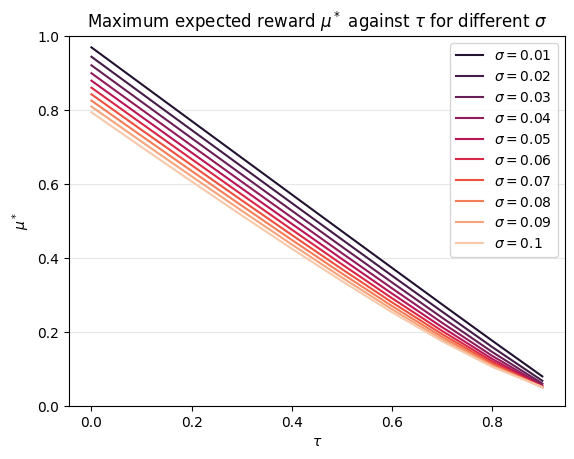

In [123]:
tau_array = np.arange(0 ,1, 0.1)
sigma_list = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
colors = sns.color_palette("rocket", len(sigma_list))
for i, sigma in enumerate(sigma_list):
    plt.plot(tau_array, 
             [get_optimal_mu(partition, tau, sigma) for tau in tau_array], 
             label = r"$\sigma =$" + str(sigma),
             c = colors[i])
plt.ylim((0, bsup))
plt.xlabel(r"$\tau$")
plt.ylabel(r"$\mu^*$")
plt.legend()
plt.title(r"Maximum expected reward $\mu^*$ against $\tau$ for different $\sigma$")
plt.grid(axis = "y", alpha = 0.3)
plt.show()

In [ ]:
# def reward(bid, tau):
#     return (sup_y - bid) * (tau <= bid)
# def find_dom(list_ball, bid):
#     activated_ball = []
#     for index_ball, ball in enumerate(list_ball):
#         if (bid > ball[0]) and (bid < ball[1]):
#             to_remove = []
#             unwanted = False
#             for active in activated_ball:
#                 if (list_ball[active][0] <= ball[0]) and (list_ball[active][1] >= ball[1]):
#                     to_remove.append(active)
#                 elif (list_ball[active][0] >= ball[0]) and (list_ball[active][1] <= ball[1]):
#                     unwanted = True
#                     break
#             if unwanted:
#                 continue
#             for active in to_remove:
#                 activated_ball.remove(active)
#             activated_ball.append(index_ball)
#     return activated_ball
# def conf_B(horizon_T, n_B):
#     return 4 * np.sqrt(np.log(horizon_T)/(1 + n_B))
# def get_best(list_ball, active_ball, reward, horizon_T):
#     selected = -1
#     best_rew = -1
#     for ind in active_ball:
#         rew = reward[ind][0]/max(1, reward[0][1]) + (list_ball[ind][1] - list_ball[ind][1]) / 2 + conf_B(horizon_T, reward[ind][1])
#         if best_rew < rew:
#             best_rew = rew
#             selected = ind
#     return selected
# Zooming algorithm
# # Input Space: [0,1]; distance norm 1
# # rndm.seed(123)
# T = 500
# prices = rndm.normal(0.7, 0.05, T)
# # Init:
# inf_y = 0
# sup_y = 1
# list_ball = []
# reward_ball = []
# list_ball.append((inf_y, sup_y))
# reward_ball.append([0,0])
# bids = np.zeros(T)
# bids[0] = list_ball[0][0] + (list_ball[0][1] - list_ball[0][0]) * rndm.rand()
# list_ind = [0]
# for t, threshold in enumerate(prices):
#     delta = bids[t] >= threshold
#     relevant = find_dom(list_ball, bids[t])
#     ind_ball = get_best(list_ball, relevant, reward_ball, T)
#     list_ind.append(ind_ball)
#     reward_ball[ind_ball] = [reward_ball[ind_ball][0] + reward(bids[t], threshold), reward_ball[ind_ball][1] + 1]
#     # if conf_B(T, reward_ball[ind_ball][1]) <= (list_ball[ind_ball][1] - list_ball[ind_ball][0]) / 2:
#     if conf_B(T, reward_ball[ind_ball][1]) <= (list_ball[ind_ball][1] - list_ball[ind_ball][0]):
#         if delta == 0:
#             # inf_new = bids[t]
#             # sup_new = (bids[t] + list_ball[ind_ball][1])/2
#             inf_new = bids[t]
#             sup_new = list_ball[ind_ball][1]
#         else:
#             # inf_new = (list_ball[ind_ball][0] + bids[t])/2
#             # sup_new = bids[t]
#             inf_new = list_ball[ind_ball][0]
#             sup_new = bids[t]
#         list_ball.append((inf_new, sup_new))
#         reward_ball.append([0,0])
#     if t < T - 1:
#         bids[t + 1] = list_ball[ind_ball][0] + (list_ball[ind_ball][1] - list_ball[ind_ball][0]) * rndm.rand()

In [ ]:
# # New zooming algorithm
# # Input Space: [0,1]; distance norm 1
# rndm.seed(123)
# T = 500
# prices = rndm.normal(0.6, 0.01, T)
# # Init:
# inf_y = 0
# sup_y = 1
# reward_ball = []
# list_ball = [(inf_y, (sup_y + inf_y) / 2), ((sup_y + inf_y) / 2, sup_y)]
# reward_ball += [[0, 0], [0, 0]]
# nb_round = 4
# round_depth = 1
# ind_down = 0
# ind_up = 1
# current_index = [(ind_down, ind_up)]
# bids = np.zeros(T)
# keep_track_ball = []
# for t, threshold in enumerate(prices):
#     if round_depth <= nb_round / 2:
#         bids[t] = list_ball[ind_down][0] + (list_ball[ind_down][1] - list_ball[ind_down][0]) * rndm.rand()
#         reward_ball[ind_down] = [reward_ball[ind_down][0] + reward(bids[t], threshold), reward_ball[ind_down][1] + 1]
#     else:
#         bids[t] = list_ball[ind_up][0] + (list_ball[ind_up][1] - list_ball[ind_up][0]) * rndm.rand()
#         reward_ball[ind_up] = [reward_ball[ind_up][0] + reward(bids[t], threshold), reward_ball[ind_up][1] + 1]
#     round_depth += 1
#     if round_depth == nb_round + 1:
#         keep_track_ball += [(list_ball[ind_down][0], list_ball[ind_up][1])]
#         new = False
#         if len(current_index) == 1:
#             new = True
#         else:
#             parent_down = current_index[-2][0]
#             parent_up = current_index[-2][1]
#             mean_reward_children = (reward_ball[ind_down][0] + reward_ball[ind_up][0]) / max(1, reward_ball[ind_down][1] + reward_ball[ind_up][1])
#             mean_reward_parents = (reward_ball[parent_down][0] + reward_ball[parent_up][0]) / max(1, reward_ball[parent_down][1] + reward_ball[parent_up][1])
#             if mean_reward_children <= mean_reward_parents:
#                 current_index = current_index[:-1]
#                 ind_down = parent_down
#                 ind_up = parent_up
#             else:
#                 new = True
#         if new:
#             if reward_ball[ind_up][0] / max(1, reward_ball[ind_up][1]) < reward_ball[ind_down][0] / max(1, reward_ball[ind_down][1]):
#                 new_ind = ind_down
#             else:
#                 new_ind = ind_up
#             new_down = (list_ball[new_ind][0], (list_ball[new_ind][0] + list_ball[new_ind][1]) / 2 )
#             new_up = ((list_ball[new_ind][0] + list_ball[new_ind][1]) / 2, list_ball[new_ind][1])
#             if new_down in list_ball:
#                 ind_down = list_ball.index(new_down)
#             else:
#                 ind_down = len(list_ball)
#                 list_ball += [new_down, new_up]
#                 reward_ball += [[0, 0], [0, 0]]
#             ind_up = ind_down + 1
#             current_index.append((ind_down, ind_up))
#         round_depth = 1